# NIX to MNE FIF Converter

This notebook converts NIX-formatted HDF5 files from the Boran dataset to MNE-compatible FIF format.

**Dataset:** Boran et al. (2020) - Human medial temporal lobe neurons, scalp and intracranial EEG during verbal working memory task

**Features:**
- Converts iEEG and scalp EEG data
- Preserves channel positions (MNI for iEEG, head coords for EEG)
- Extracts trial events (Fixation, Stimulus, Maintenance, Probe, Response)
- Creates STI channel with event codes
- Batch processes multiple sessions

## 1. Imports

In [1]:
import h5py
import numpy as np
import mne
import pandas as pd
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import matplotlib
import os
import pandas as pd
import re 

# Uncomment for interactive plotting
# matplotlib.use("Qt5Agg")

## 2. Converter Class

In [10]:
class NIXToMNEConverter:
    """
    Convert NIX-formatted HDF5 files to MNE-compatible formats.
    
    This converter handles the dataset from:
    "Dataset of human medial temporal lobe neurons, scalp and intracranial 
    EEG during a verbal working memory task"
    
    Features:
    - Converts iEEG and scalp EEG data
    - Preserves channel positions (MNI for iEEG, head coords for EEG)
    - Extracts trial events with cleaned names (fixation, encoding, etc.)
    - Creates STI channel with event codes
    - Extracts behavioral metadata (accuracy, RT, set size, etc.)
    - Supports single trial or full session conversion
    """
    
    def __init__(self, filepath: str, verbose: bool = True):
        """
        Initialize converter.
        
        Parameters
        ----------
        filepath : str
            Path to the NIX HDF5 file (e.g., 'Data_Subject_01_Session_01.h5')
        verbose : bool
            Print debug information
        """
        self.filepath = filepath
        self.file = None
        self.metadata = {}
        self.verbose = verbose
        
    def _log(self, message: str):
        """Print message if verbose."""
        if self.verbose:
            print(f"[NIX->MNE] {message}")
        
    def __enter__(self):
        self.file = h5py.File(self.filepath, 'r')
        self._log(f"Opened file: {self.filepath}")
        return self
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.file:
            self.file.close()
    
    def _safe_decode(self, value):
        """Safely decode bytes to string."""
        if isinstance(value, bytes):
            return value.decode('utf-8')
        elif isinstance(value, np.ndarray):
            if value.dtype.kind in ('S', 'O'):
                if len(value) == 1:
                    value = value[0]
                if isinstance(value, bytes):
                    return value.decode('utf-8')
                return str(value)
        return value
    
    def _clean_event_name(self, raw_name: str) -> str:
        """
        Clean event name to simple lowercase format.
        
        Handles Boran dataset event naming:
        'fixation1_ss8_c1_m2' → 'fixation'
        'stimulus_ss8_xxxxxxxx' → 'encoding'
        'probe_iw1_t' → 'retrieval'
        'resp' → 'response'
        'event_maintenance_scalp_eeg' → 'maintenance'
        """
        name = raw_name
        
        # Convert to lowercase first
        name = name.lower()
        
        # Remove trial prefix (Trial_XX_)
        name = re.sub(r'trial_\d+_', '', name)
        
        # Remove common prefixes
        name = name.replace('event_', '')
        
        # Remove data type suffixes
        name = name.replace('_scalp_eeg', '')
        name = name.replace('_scalp', '')
        name = name.replace('_ieeg', '')
        name = name.replace('_seeg', '')
        name = name.replace('_eeg', '')
        
        # Remove trial parameters (ss8, c1, m2, iw1, etc.)
        # Pattern: _ssX, _cX, _mX, _iwX, _tX, etc.
        name = re.sub(r'_ss\d+', '', name)  # set size
        name = re.sub(r'_c\d+', '', name)   # correct
        name = re.sub(r'_m\d+', '', name)   # match
        name = re.sub(r'_iw\d+', '', name)  # item within
        name = re.sub(r'_t\d*', '', name)   # time/trial marker
        
        # Remove numbers at end (fixation1 → fixation)
        name = re.sub(r'\d+$', '', name)
        
        # Remove trailing underscores and x's
        name = re.sub(r'[_x]+$', '', name)
        
        # Map specific terms to standard names
        mappings = {
            'fixation': 'fixation',
            'stimulus': 'encoding',
            'stim': 'encoding',
            'probe': 'retrieval',
            'resp': 'response',
            'response': 'response',
            'maintenance': 'maintenance',
            'delay': 'maintenance',
        }
        
        # Try to find a matching mapping
        for key, value in mappings.items():
            if key in name:
                return value
        
        # Remove common suffixes/extra info
        name = name.replace('_probe', '')
        name = name.replace('_onset', '')
        name = name.replace('_offset', '')
        name = name.replace('_start', '')
        name = name.replace('_end', '')
        name = name.replace('_period', '')
        name = name.replace('_phase', '')
        name = name.replace('_button', '')
        
        # Strip whitespace and underscores
        name = name.strip()
        name = name.strip('_')
        
        return name
    
    def _get_block(self):
        """Get the data block from the file."""
        block_name = list(self.file['data'].keys())[0]
        return self.file['data'][block_name]
    
    def _extract_property_value(self, prop):
        """Extract value from NIX property dataset."""
        try:
            if isinstance(prop, h5py.Dataset):
                raw_data = prop[()]
                
                if hasattr(raw_data.dtype, 'names') and raw_data.dtype.names is not None:
                    if 'value' in raw_data.dtype.names:
                        value_field = raw_data['value']
                        
                        if len(value_field) > 0:
                            value = value_field[0]
                            
                            if isinstance(value, (bytes, np.bytes_)):
                                return value.decode('utf-8')
                            else:
                                return value
                    else:
                        first_field = raw_data.dtype.names[0]
                        value = raw_data[first_field][0] if len(raw_data) > 0 else None
                        return self._safe_decode(value)
                else:
                    return self._safe_decode(raw_data)
            
            return None
            
        except Exception as e:
            return None
    
    def extract_trial_metadata(self) -> pd.DataFrame:
        """
        Extract behavioral metadata for all trials.
        
        Returns
        -------
        metadata : pd.DataFrame
            DataFrame with columns:
            - trial_number: Trial index
            - set_size: Memory load (4, 6, or 8 items)
            - match: Match (1) or non-match (0) trial
            - correct: Response accuracy (1=correct, 0=incorrect)
            - response: Button press response
            - response_time: Reaction time in seconds
            - probe_letter: Probe stimulus letter
        """
        metadata_list = []
        
        if 'metadata' not in self.file:
            self._log("No metadata section")
            return pd.DataFrame()
        
        meta = self.file['metadata']
        
        # Find Session section
        session_section = None
        for key in meta.keys():
            if 'Session' in self._safe_decode(key):
                session_section = meta[key]
                break
        
        if session_section is None or 'sections' not in session_section:
            self._log("Session/sections not found")
            return pd.DataFrame()
        
        # Find Trial properties section
        trial_props_section = None
        for key in session_section['sections'].keys():
            subsec = session_section['sections'][key]
            name = self._safe_decode(key)
            
            try:
                if 'name' in subsec.attrs:
                    name = self._safe_decode(subsec.attrs['name'])
            except:
                pass
            
            if 'Trial' in name and 'properties' in name:
                trial_props_section = subsec
                self._log(f"Found: {name}")
                break
        
        if trial_props_section is None or 'sections' not in trial_props_section:
            self._log("Trial properties/sections not found")
            return pd.DataFrame()
        
        trial_sections = trial_props_section['sections']
        n_trials = len(trial_sections)
        self._log(f"Found {n_trials} trials")
        
        # Extract data from each trial
        for trial_idx, trial_key in enumerate(sorted(trial_sections.keys())):
            trial = trial_sections[trial_key]
            
            trial_data = {}
            
            if 'properties' in trial:
                props = trial['properties']
                
                for prop_key in props.keys():
                    try:
                        prop = props[prop_key]
                        
                        prop_name = self._safe_decode(prop_key)
                        if 'name' in prop.attrs:
                            prop_name = self._safe_decode(prop.attrs['name'])
                        
                        value = self._extract_property_value(prop)
                        
                        # DEBUG: Print response time extraction
                        if 'response' in prop_name.lower() and 'time' in prop_name.lower():
                            self._log(f"  Trial {trial_idx}: RT property='{prop_name}', raw_value={value}, type={type(value)}")
                            # Force proper extraction if boolean
                            if isinstance(value, (bool, np.bool_)):
                                if hasattr(prop, 'value'):
                                    value = float(prop.value[()])
                                elif hasattr(prop, 'data'):
                                    value = float(prop.data[()])
                                self._log(f"    Corrected to: {value}")
                        
                        if value is not None:
                            prop_lower = prop_name.lower()
                            
                            if 'trial' in prop_lower and 'number' in prop_lower:
                                trial_data['trial_number'] = value
                            elif 'set' in prop_lower and 'size' in prop_lower:
                                trial_data['set_size'] = value
                            elif 'match' in prop_lower and 'probe' not in prop_lower:
                                trial_data['match'] = value
                            elif 'correct' in prop_lower:
                                trial_data['correct'] = value
                            elif 'response' in prop_lower and 'time' not in prop_lower:
                                trial_data['response'] = value
                            elif 'response' in prop_lower and 'time' in prop_lower:
                                # Only store numeric RT values
                                if isinstance(value, (int, float, np.integer, np.floating)):
                                    trial_data['response_time'] = value
                            elif 'probe' in prop_lower or 'letter' in prop_lower or 'stimulus' in prop_lower:
                                trial_data['probe_letter'] = value
                    except Exception as e:
                        self._log(f"  Error extracting {prop_key}: {e}")
                        continue
            if trial_idx == 0:
                self._log(f"  trial_data dict: {trial_data}")
            row = {
                'trial_number': trial_data.get('trial_number', trial_idx + 1),
                'set_size': trial_data.get('set_size', np.nan),
                'match': trial_data.get('match', np.nan),
                'correct': trial_data.get('correct', np.nan),
                'response': trial_data.get('response', np.nan),
                'response_time': trial_data.get('response_time', np.nan),
                'probe_letter': trial_data.get('probe_letter', ''),
            }
            
            metadata_list.append(row)
        if metadata_list:
            df = pd.DataFrame(metadata_list)
            
            # DEBUG: Check values BEFORE numeric conversion
            self._log(f"  RT before conversion (first 5): {df['response_time'].head().tolist()}")
            
            # Convert to numeric types
            numeric_cols = ['trial_number', 'set_size', 'match', 'correct', 'response', 'response_time']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # DEBUG: Check values AFTER numeric conversion  
            self._log(f"  RT after conversion (first 5): {df['response_time'].head().tolist()}")
            self._log(f"  RT dtype: {df['response_time'].dtype}")
        if metadata_list:
            df = pd.DataFrame(metadata_list)
            
            # Convert to numeric types
            numeric_cols = ['trial_number', 'set_size', 'match', 'correct', 'response', 'response_time']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            
            self._log(f"Extracted metadata for {len(df)} trials")
            
            # Show summary
            non_empty = [col for col in df.columns 
                        if df[col].notna().any() and col != 'trial_number']
            
            if non_empty:
                self._log(f"  Columns with data: {non_empty}")
                
                if 'correct' in non_empty:
                    self._log(f"  Accuracy: {df['correct'].mean()*100:.1f}%")
                if 'response_time' in non_empty:
                    self._log(f"  Mean RT: {df['response_time'].mean():.3f}s")
            
            return df
        
        return pd.DataFrame()    
    def save_metadata(self, output_path: str, metadata: pd.DataFrame):
        """Save metadata as CSV."""
        if len(metadata) > 0:
            metadata.to_csv(output_path, index=False)
            self._log(f"Saved metadata to {output_path}")
    
    def _get_channel_info(self, data_type: str = 'iEEG') -> Tuple[List[str], Optional[np.ndarray]]:
        """
        Extract channel names and positions.
        
        Positions are in MNI coordinates (mm) for iEEG,
        or EEGLAB/BESA coordinates (mm) for scalp EEG.
        """
        block = self._get_block()
        
        ch_names = []
        positions = None
        
        # Get channel names from first trial data array
        group_name = 'iEEG data' if data_type == 'iEEG' else 'Scalp EEG data'
        
        if 'groups' in block and group_name in block['groups']:
            group = block['groups'][group_name]
            
            if 'data_arrays' in group:
                # Get first data array
                first_da_key = list(group['data_arrays'].keys())[0]
                first_da = group['data_arrays'][first_da_key]
                
                # Extract channel labels from dimension 1 (Set dimension)
                if 'dimensions' in first_da:
                    for dim_key in first_da['dimensions'].keys():
                        dim = first_da['dimensions'][dim_key]
                        if 'dimension_type' in dim.attrs:
                            dim_type = self._safe_decode(dim.attrs['dimension_type'])
                            if dim_type == 'set' and 'labels' in dim:
                                labels = dim['labels'][()]
                                ch_names = [self._safe_decode(label) for label in labels]
                                break
        
        # Get electrode positions
        if data_type == 'iEEG':
            elec_group_name = 'iEEG electrode information'
            coord_array_name = 'iEEG_Electrode_MNI_Coordinates'
        else:
            elec_group_name = 'Scalp EEG electrode information'
            coord_array_name = 'Scalp_Electrode_EEGLAB_BESA_Coordinates'
        
        if 'groups' in block and elec_group_name in block['groups']:
            elec_group = block['groups'][elec_group_name]
            
            if 'data_arrays' in elec_group:
                for da_key in elec_group['data_arrays'].keys():
                    da = elec_group['data_arrays'][da_key]
                    
                    if 'name' in da.attrs:
                        da_name = self._safe_decode(da.attrs['name'])
                        
                        if da_name == coord_array_name:
                            if 'data' in da:
                                positions = da['data'][()]
                            break
        
        self._log(f"Found {len(ch_names)} channels")
        return ch_names, positions
    
    def _get_trial_data(self, trial_num: int, data_type: str = 'iEEG') -> Tuple[np.ndarray, float, float]:
        """
        Extract data for a specific trial.
        
        Returns
        -------
        data : ndarray
            Data array (channels x timepoints) in µV
        sfreq : float
            Sampling frequency in Hz
        offset : float
            Time offset in seconds
        """
        block = self._get_block()
        
        group_name = 'iEEG data' if data_type == 'iEEG' else 'Scalp EEG data'
        
        if 'groups' not in block or group_name not in block['groups']:
            raise ValueError(f"Group '{group_name}' not found")
        
        group = block['groups'][group_name]
        
        if 'data_arrays' not in group:
            raise ValueError(f"No data arrays")
        
        da_keys = sorted(list(group['data_arrays'].keys()))
        
        if trial_num >= len(da_keys):
            raise ValueError(f"Trial {trial_num} not found")
        
        da_key = da_keys[trial_num]
        da = group['data_arrays'][da_key]
        
        # Extract data
        raw_data = da['data'][()]
        
        # Ensure correct shape (channels x timepoints)
        if raw_data.shape[0] > raw_data.shape[1]:
            data = raw_data.T
        else:
            data = raw_data
        
        # Extract sampling parameters
        sfreq = None
        offset = 0.0
        
        if 'dimensions' in da:
            for dim_key in da['dimensions'].keys():
                dim = da['dimensions'][dim_key]
                if 'dimension_type' in dim.attrs:
                    dim_type = self._safe_decode(dim.attrs['dimension_type'])
                    
                    if dim_type == 'sample':
                        if 'sampling_interval' in dim.attrs:
                            dt = float(dim.attrs['sampling_interval'][()])
                            sfreq = 1.0 / dt
                        
                        if 'offset' in dim.attrs:
                            offset = float(dim.attrs['offset'][()])
        
        if sfreq is None:
            raise ValueError("Could not determine sampling frequency")
        
        return data, sfreq, offset
    
    def _get_trial_events_from_tags(self, trial_num: int, data_type: str = 'iEEG') -> Dict[str, float]:
        """
        Extract events from 'Trial events single tags' group.
        Returns dict mapping cleaned event name to event time.
        """
        block = self._get_block()
        events = {}
        
        # Determine correct group name based on data type
        if data_type == 'iEEG':
            events_group_name = 'Trial events single tags iEEG'
        else:
            events_group_name = 'Trial events single tags scalp EEG'
        
        if 'groups' not in block:
            return events
        
        if events_group_name not in block['groups']:
            return events
        
        events_group = block['groups'][events_group_name]
        
        if 'tags' not in events_group:
            return events
        
        tags = events_group['tags']
        
        # Format trial number with zero padding (Trial_01, Trial_02, etc.)
        trial_str = f"Trial_{trial_num+1:02d}"
        
        # Find all tags for this trial
        for tag_key in tags.keys():
            tag = tags[tag_key]
            
            # Get tag name
            tag_name = self._safe_decode(tag_key)
            if 'name' in tag.attrs:
                tag_name = self._safe_decode(tag.attrs['name'])
            
            # Check if this tag belongs to our trial
            if trial_str in tag_name:
                # Extract and clean event name
                event_name = tag_name.replace(trial_str + '_', '').replace(trial_str, '')
                event_name = self._clean_event_name(event_name)
                
                # Get event position (time)
                if 'position' in tag:
                    position = tag['position'][()]
                    
                    # Position might be array
                    if isinstance(position, np.ndarray):
                        if len(position) > 0:
                            # Get second element (time), first is usually index
                            if len(position) >= 2:
                                event_time = float(position[1])
                            else:
                                event_time = float(position[0])
                        else:
                            continue
                    else:
                        event_time = float(position)
                    
                    events[event_name] = event_time
        
        return events
    
    def get_trial_count(self, data_type: str = 'iEEG') -> int:
        """Get number of trials in the session."""
        block = self._get_block()
        group_name = 'iEEG data' if data_type == 'iEEG' else 'Scalp EEG data'
        
        if 'groups' in block and group_name in block['groups']:
            group = block['groups'][group_name]
            if 'data_arrays' in group:
                return len(group['data_arrays'])
        
        return 0
    
    def convert_session_to_raw(self, data_type: str = 'iEEG',
                              trials: Optional[List[int]] = None,
                              add_events: bool = True,
                              events_as_stim: bool = True) -> mne.io.RawArray:
        """
        Convert entire session to a single continuous MNE Raw object.
        
        All trials are concatenated into one continuous recording.
        Event names are automatically cleaned (e.g., 'event_maintenance_scalp_eeg' → 'maintenance').
        
        Parameters
        ----------
        data_type : str
            'iEEG' or 'Scalp_EEG'
        trials : list, optional
            List of trial numbers (0-indexed). If None, uses all trials.
        add_events : bool
            If True, add events as annotations
        events_as_stim : bool
            If True, create a STI channel with event codes
            
        Returns
        -------
        raw : mne.io.RawArray
            Continuous Raw object with all trials concatenated
        """
        ch_names, positions = self._get_channel_info(data_type)
        
        if not ch_names:
            raise ValueError(f"No channel names found for {data_type}")
        
        num_trials = self.get_trial_count(data_type)
        
        if trials is None:
            trials = list(range(num_trials))
        
        self._log(f"Converting {len(trials)} trials...")
        
        # Allocate arrays
        all_data = []
        all_annotations_onset = []
        all_annotations_duration = []
        all_annotations_description = []
        
        sfreq = None
        current_time = 0.0
        
        n_events_per_trial = []
        
        # Process each trial
        for trial_idx, trial_num in enumerate(trials):
            data, trial_sfreq, offset = self._get_trial_data(trial_num, data_type)
            
            if sfreq is None:
                sfreq = trial_sfreq
            
            # Convert µV to V
            data = data * 1e-6
            all_data.append(data)
            
            # Extract events
            if add_events:
                events = self._get_trial_events_from_tags(trial_num, data_type)
                n_events_per_trial.append(len(events))
                
                for event_name, event_time in events.items():
                    adjusted_time = current_time + (event_time - offset)
                    all_annotations_onset.append(adjusted_time)
                    all_annotations_duration.append(0.0)
                    all_annotations_description.append(event_name)
            
            trial_duration = data.shape[1] / sfreq
            current_time += trial_duration
            
            if (trial_idx + 1) % 10 == 0:
                self._log(f"Processed {trial_idx + 1}/{len(trials)} trials")
        
        # Concatenate data
        combined_data = np.hstack(all_data)
        
        # Debug event extraction
        if add_events:
            self._log(f"Event extraction summary:")
            self._log(f"  Total annotations: {len(all_annotations_onset)}")
            if n_events_per_trial:
                self._log(f"  Events per trial: min={min(n_events_per_trial)}, max={max(n_events_per_trial)}")
            
            if len(all_annotations_description) > 0:
                unique_events = sorted(set(all_annotations_description))
                self._log(f"  Unique event types: {unique_events}")
        
        # Create STI channel
        if add_events and events_as_stim and len(all_annotations_description) > 0:
            stim_data = np.zeros((1, combined_data.shape[1]))
            
            event_names = sorted(set(all_annotations_description))
            event_name_to_code = {name: idx + 1 for idx, name in enumerate(event_names)}
            
            self._log(f"Creating STI channel with {len(event_name_to_code)} event types:")
            for name, code in sorted(event_name_to_code.items(), key=lambda x: x[1]):
                self._log(f"    {name}: code {code}")
            
            # Encode events
            n_encoded = 0
            for onset, desc in zip(all_annotations_onset, all_annotations_description):
                sample = int(onset * sfreq)
                if 0 <= sample < stim_data.shape[1]:
                    stim_data[0, sample] = event_name_to_code[desc]
                    n_encoded += 1
            
            self._log(f"  Encoded {n_encoded}/{len(all_annotations_onset)} events to STI channel")
            self._log(f"  STI channel non-zero samples: {np.sum(stim_data != 0)}")
            
            combined_data = np.vstack([combined_data, stim_data])
            ch_names_with_sti = ch_names + ['STI']
            ch_types = [('seeg' if data_type == 'iEEG' else 'eeg')] * len(ch_names) + ['stim']
        else:
            if add_events and len(all_annotations_description) == 0:
                self._log("  ⚠ WARNING: No events found to encode!")
            ch_names_with_sti = ch_names
            ch_types = ('seeg' if data_type == 'iEEG' else 'eeg')
        
        # Create info
        info = mne.create_info(ch_names=ch_names_with_sti, sfreq=sfreq, ch_types=ch_types)
        
        # Add positions
        if positions is not None:
            for idx, ch_name in enumerate(ch_names):
                if idx < len(positions):
                    pos = positions[idx] / 1000.0  # mm to m
                    info['chs'][idx]['loc'][:3] = pos
        
        # Create Raw
        raw = mne.io.RawArray(combined_data, info)
        
        # Store event codes
        if add_events and events_as_stim and len(all_annotations_description) > 0:
            raw.info['temp'] = {'event_id': event_name_to_code}
        
        # Add annotations
        if add_events and all_annotations_onset:
            annotations = mne.Annotations(
                onset=all_annotations_onset,
                duration=all_annotations_duration,
                description=all_annotations_description
            )
            raw.set_annotations(annotations)
        
        duration = len(raw.times) / sfreq
        self._log(f"Created Raw: {duration:.1f}s, {len(ch_names)} channels")
        
        return raw
    
    def convert_session_with_metadata(self, 
                                      data_type: str = 'iEEG',
                                      output_fif: str = None,
                                      output_csv: str = None,
                                      add_events: bool = True,
                                      events_as_stim: bool = True):
        """
        Convert session to Raw AND extract behavioral metadata.
        
        Parameters
        ----------
        data_type : str
            'iEEG' or 'Scalp_EEG'
        output_fif : str, optional
            Path to save FIF file
        output_csv : str, optional
            Path to save metadata CSV
        add_events : bool
            Add events as annotations and STI channel
        events_as_stim : bool
            Create STI channel with event codes
        
        Returns
        -------
        raw : mne.io.RawArray
            Converted neural data
        metadata : pd.DataFrame
            Behavioral metadata
        """
        # Extract metadata
        metadata = self.extract_trial_metadata()
        
        # Convert neural data
        raw = self.convert_session_to_raw(
            data_type=data_type,
            add_events=add_events,
            events_as_stim=events_as_stim
        )
        
        # Save if requested
        if output_fif:
            raw.save(output_fif, overwrite=True)
            print(f"✓ Saved FIF: {output_fif}")
        
        if output_csv and len(metadata) > 0:
            self.save_metadata(output_csv, metadata)
        
        return raw, metadata

## 3. Usage Examples

### 3.1 Convert Single File

In [ ]:
if __name__ == "__main__":
    filepath = r'data_nix/Data_Subject_01_Session_01.h5'
    
    print("="*80)
    print("NIX CONVERTER - INTEGRATED VERSION")
    print("="*80)
    print(f"\nFile: {filepath}\n")
    
    with NIXToMNEConverter(filepath, verbose=True) as converter:
        # Convert with metadata extraction
        raw, metadata = converter.convert_session_with_metadata(
            data_type='Scalp_EEG',  # or 'Scalp_EEG'
            output_fif='session_ieeg_raw.fif',
            output_csv='session_Metadata.csv',
            add_events=True,
            events_as_stim=True
        )
        
        print("\n" + "="*80)
        print("VERIFICATION")
        print("="*80)
        
        # Check STI channel
        if 'STI' in raw.ch_names:
            stim_data = raw.get_data(picks='STI')[0]
            print(f"✓ STI channel present")
            print(f"  Non-zero samples: {np.sum(stim_data != 0)}")
            print(f"  Unique values: {np.unique(stim_data)}")
            
            # Extract events
            events = mne.find_events(raw, stim_channel='STI', verbose=False)
            print(f"✓ Extracted {len(events)} events")
            if len(events) > 0:
                print(f"  Event codes: {np.unique(events[:, 2])}")
        else:
            print(f"❌ No STI channel!")
        
        print(f"\n✓ Annotations: {len(raw.annotations)}")
        print(f"✓ Metadata: {len(metadata)} trials")
        
        if len(metadata) > 0:
            print(f"\nMetadata columns: {list(metadata.columns)}")
            if 'correct' in metadata.columns:
                acc = metadata['correct'].mean() * 100
                print(f"  Accuracy: {acc:.1f}%")
            if 'response_time' in metadata.columns:
                rt = metadata['response_time'].mean()
                print(f"  Mean RT: {rt:.3f}s")

NIX CONVERTER - INTEGRATED VERSION

File: data_nix/Data_Subject_01_Session_01.h5

[NIX->MNE] Opened file: data_nix/Data_Subject_01_Session_01.h5
[NIX->MNE] Found: Trial properties
[NIX->MNE] Found 50 trials
[NIX->MNE]   Trial 0: RT property='Response time', raw_value=2.484, type=<class 'numpy.float64'>
[NIX->MNE]   trial_data dict: {'trial_number': np.float64(1.0), 'set_size': np.float64(8.0), 'match': np.float64(2.0), 'correct': np.float64(1.0), 'response': np.float64(52.0), 'response_time': np.float64(2.484), 'probe_letter': 'H'}
[NIX->MNE]   Trial 1: RT property='Response time', raw_value=1.66775, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 2: RT property='Response time', raw_value=1.472, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 3: RT property='Response time', raw_value=1.30875, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 4: RT property='Response time', raw_value=1.51625, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 5: RT property='Response time', raw_value=0.899, 

### 3.2 Batch Convert All Files

In [12]:
# Batch convert all files in directory
input_directory = "data_nix"
output_directory = "Data_converted_MetaData"

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Process each file
for filename in sorted(os.listdir(input_directory)):
    if filename.endswith('.h5'):
        input_path = os.path.join(input_directory, filename)
        output_path_fif = os.path.join(output_directory,filename[5:15], f"{filename}_seeg_raw.fif")
        output_path_csv = os.path.join(output_directory,filename[5:15] , f"{filename}_seeg_raw.csv")

        print(f"\nProcessing: {filename}")
        print("=" * 80)
        
        with NIXToMNEConverter(input_path, verbose=True) as converter:
        # Convert with metadata extraction
            raw, metadata = converter.convert_session_with_metadata(
                data_type='Scalp_EEG',  # or 'Scalp_EEG'
                output_fif= output_path_fif,
                output_csv= output_path_csv,
                add_events=True,
                events_as_stim=True
            )
            
            events = mne.find_events(raw, stim_channel='STI', 
                                    min_duration=0,
                                    shortest_event=1,
                                    verbose=False)
            


Processing: Data_Subject_01_Session_01.h5
[NIX->MNE] Opened file: data_nix\Data_Subject_01_Session_01.h5
[NIX->MNE] Found: Trial properties
[NIX->MNE] Found 50 trials
[NIX->MNE]   Trial 0: RT property='Response time', raw_value=2.484, type=<class 'numpy.float64'>
[NIX->MNE]   trial_data dict: {'trial_number': np.float64(1.0), 'set_size': np.float64(8.0), 'match': np.float64(2.0), 'correct': np.float64(1.0), 'response': np.float64(52.0), 'response_time': np.float64(2.484), 'probe_letter': 'H'}
[NIX->MNE]   Trial 1: RT property='Response time', raw_value=1.66775, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 2: RT property='Response time', raw_value=1.472, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 3: RT property='Response time', raw_value=1.30875, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 4: RT property='Response time', raw_value=1.51625, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 5: RT property='Response time', raw_value=0.899, type=<class 'numpy.float64'>
[NIX->MNE]

C:\Users\RSKALA\AppData\Local\Temp\ipykernel_22072\3854511179.py:692: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


[NIX->MNE]   Trial 30: RT property='Response time', raw_value=0.944, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 31: RT property='Response time', raw_value=0.8965, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 32: RT property='Response time', raw_value=1.28425, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 33: RT property='Response time', raw_value=0.92575, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 34: RT property='Response time', raw_value=1.0435, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 35: RT property='Response time', raw_value=0.89225, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 36: RT property='Response time', raw_value=0.858, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 37: RT property='Response time', raw_value=0.76175, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 38: RT property='Response time', raw_value=2.0985, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 39: RT property='Response time', raw_value=1.806, type=<class 'numpy.float64'>
[NIX->MNE

C:\Users\RSKALA\AppData\Local\Temp\ipykernel_22072\3854511179.py:692: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


[NIX->MNE]   Trial 13: RT property='Response time', raw_value=1.0315, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 14: RT property='Response time', raw_value=0.97825, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 15: RT property='Response time', raw_value=1.27925, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 16: RT property='Response time', raw_value=1.593, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 17: RT property='Response time', raw_value=3.182, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 18: RT property='Response time', raw_value=1.91425, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 19: RT property='Response time', raw_value=1.08875, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 20: RT property='Response time', raw_value=1.62775, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 21: RT property='Response time', raw_value=1.80375, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 22: RT property='Response time', raw_value=1.148, type=<class 'numpy.float64'>
[NIX->M

C:\Users\RSKALA\AppData\Local\Temp\ipykernel_22072\3854511179.py:692: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  raw.set_annotations(annotations)


[NIX->MNE]   Trial 26: RT property='Response time', raw_value=1.1075, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 27: RT property='Response time', raw_value=1.094, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 28: RT property='Response time', raw_value=2.09, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 29: RT property='Response time', raw_value=1.9965, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 30: RT property='Response time', raw_value=1.24375, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 31: RT property='Response time', raw_value=2.39975, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 32: RT property='Response time', raw_value=1.01975, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 33: RT property='Response time', raw_value=1.85675, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 34: RT property='Response time', raw_value=1.0075, type=<class 'numpy.float64'>
[NIX->MNE]   Trial 35: RT property='Response time', raw_value=0.91, type=<class 'numpy.float64'>
[NIX->MNE] 

## 4. Visualization

In [48]:
# Load and plot converted data
raw = mne.io.read_raw_fif(r'Data_converted_MetaData\Subject_01\Data_Subject_01_Session_01.h5_seeg_raw.fif', preload=False)
raw.plot()

Opening raw data file Data_converted_MetaData\Subject_01\Data_Subject_01_Session_01.h5_seeg_raw.fif...
Isotrak not found
    Range : 0 ... 79999 =      0.000 ...   399.995 secs
Ready.


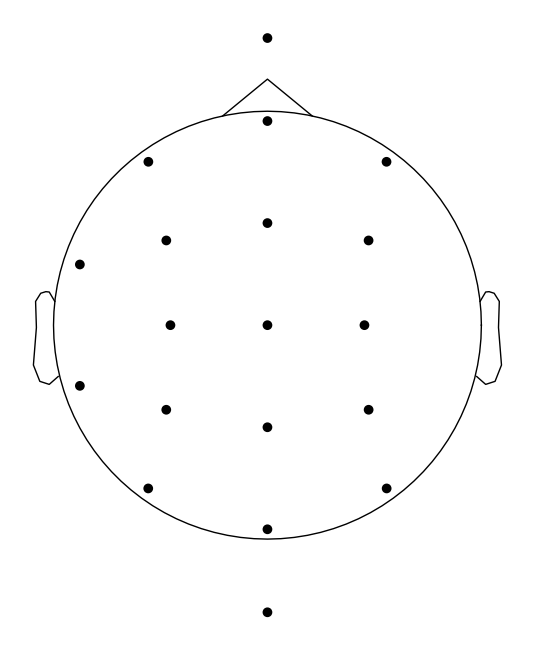

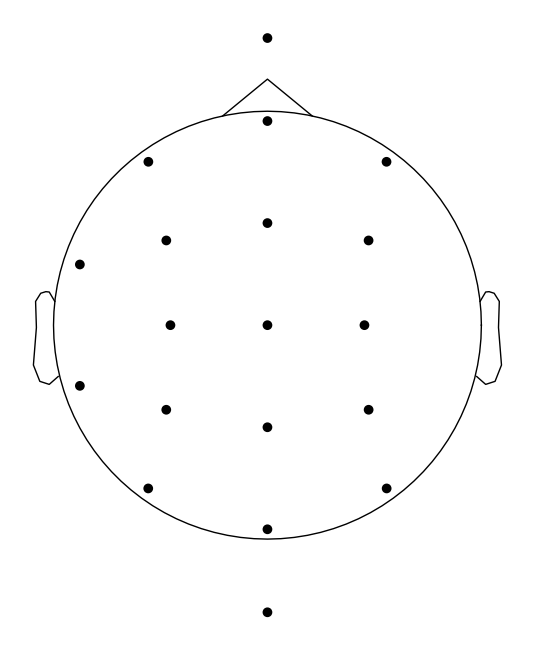

In [54]:
# Plot sensor positions
raw.plot_sensors(ch_type="all")